# Churn prediction with Logistic Regression

In this project, the goal is to predict which customers of a telecommunications company are likely to cancel their contracts. The objective is to identify potential churners and calculate their probability of leaving, enabling the company to implement targeted measures like promotional offers or discounts. This approach aims to retain customers and avoid revenue losses. It's crucial for the model to minimize unnecessary actions on customers who won’t churn, while also ensuring that no potential churners are overlooked. Additionally, the project seeks to identify the primary factors that contribute to customer churn.

Predicting customer churn is particularly relevant in the telecommunications industry, as market liberalization and technological innovations make it easy for customers to switch providers. Studies have shown that retaining existing customers is significantly more cost-effective than acquiring new ones.

Logistic regression is a well-suited algorithm for binary classification problems where the goal is to predict the probability of a customer leaving the company (1) or staying (0). Using independent variables such as contract duration, monthly charges, or services used, logistic regression can model a customer’s likelihood of churning.

These probabilities can then be used to make predictions and take targeted actions. False negatives (when a churn-risk customer is not identified as such) should be avoided, as they are particularly costly. Key metrics for evaluating the model's performance include Recall and AUC-ROC. The AUC curve is used to quantify the model’s performance across the positive and negative classes of the test set. A higher AUC value indicates that the model performs well for both positive and negative classes. The F1 score is also a useful metric, as it balances Precision and Recall, which is especially valuable when optimizing the trade-off between false positives and false negatives.

Overall, logistic regression is suitable in this context because it not only predicts churn probabilities but is also easy to interpret and, with its S-curve shape, provides clear threshold values for decision-making.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statistics import stdev

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA

# Logistic Regression

Logistic regression is a commonly used classification algorithm that can be binary, multinomial, or ordinal. In this case, it is a binary logistic regression, which predicts the likelihood that a customer will leave the company. Logistic regression models the log-odds of an event, in this case, the probability of churn, where odds are defined as the probability divided by the probability of the event not occurring.

The log-odds are defined as: 

$$ \log \left( \frac{P_i}{1 - P_i} \right) $$

Pi represents the probability that customer i will churn. Pi always takes a value between 0 and 1. Logistic regression models the log-odds as a linear function of the explanatory variables X1, X2,…, Xn. The regression equation is as follows:

$$ \log \left( \frac{P_i}{1 - P_i} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_n X_n $$

The log-odds can be predicted using a regression line. This represents a linear relationship between the explanatory variables and the log-odds. The log-odds can take values from −∞ to +∞.

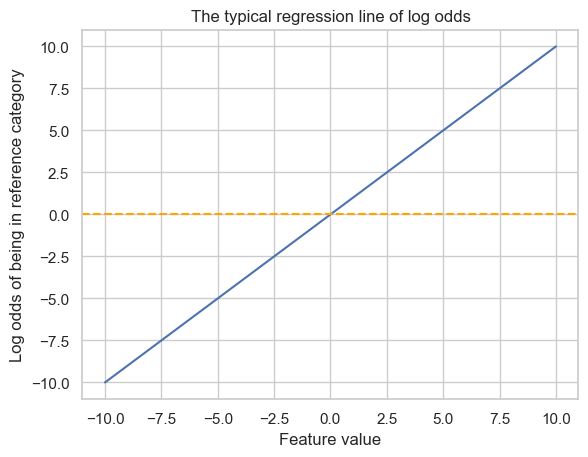

In [3]:

# Sigmoid function to generate probabilities
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# create artificial feature values
features_pred = pd.DataFrame({'feature': np.linspace(-10, 10, 100)})

# generate artificial probabilities using the sigmoid function
z = features_pred['feature']  # use feature values directly for z
target_train_pred_proba = sigmoid(z)

# calculate odds
target_train_pred_odds = target_train_pred_proba / (1 - target_train_pred_proba)

# calculate log odds
target_train_pred_log_odds = np.log(target_train_pred_odds)

# module import for visualisation
sns.set(style="whitegrid")

# line plot for log odds
ax = sns.lineplot(x=features_pred.iloc[:, 0], y=target_train_pred_log_odds)

# labels
ax.set(title='The typical regression line of log odds',
       xlabel='Feature value',
       ylabel='Log odds of being in reference category')

# orange horizontal line at 0
ax.axhline(0, ls='--', color="orange")

# show the plot
plt.show()

To convert log-odds into probabilities, the equation is rearranged to solve for Pi. This leads to the logistic function (also known as the sigmoid function), which transforms log-odds back into probabilities. The logistic function is a specific type of sigmoid function used in logistic regression to model probabilities of a specific event (e.g., a positive classification such as churn). It ensures that the probabilities always fall within the range of 0 to 1. The exponential term e-z causes the probability to approach 0 for large negative values of z and to approach 1 for large positive values.

$$ P_i = \frac{1}{1 + e^{-z}} $$

In this case:

- z is a linear combination of the input variables (β0+β1X1+⋯+βnXn).
- The logistic function returns values between 0 and 1, making it ideal for modeling probabilities in logistic regression.

$$ P_i = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + \dots + \beta_n X_n)}} $$

The prediction is based on the following components:

- Pi is the probability of the event (e.g., that the target variable yi=1),
- β0 is the intercept,
- β1…βn are the regression coefficients for the explanatory variables X1…Xn,
- e is the base of the natural logarithm,
- X1…Xn are the features (explanatory variables).

The logistic function transforms the linear expression β0+β1X1+⋯+βnXn into a probability value between 0 and 1. This transformation produces the typical S-curve that is characteristic of logistic regression.

Finally, the probability Pi is converted into a class prediction:

- If the probability Pi >0.5, the class is predicted as 1 (e.g., the customer will churn).
- If Pi ≤0.5, the class is predicted as 0 (e.g., the customer will not churn).

In this way, logistic regression enables the prediction of binary categories (e.g., "Churner" or "Non-Churner") based on a linear combination of features.

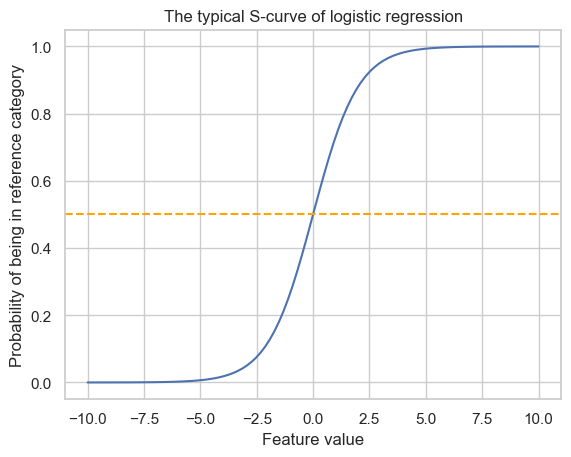

In [5]:

# create artificial feature values
features_pred = pd.DataFrame({'feature': np.linspace(-10, 10, 100)})

# generate artificial probabilities using the sigmoid function
z = features_pred['feature']  # use feature values directly for z
target_train_pred_proba = sigmoid(z)

# module import for visualisation
sns.set(style="whitegrid")

# line plot
ax = sns.lineplot(x=features_pred.iloc[:, 0], y=target_train_pred_proba)

# labels
ax.set(title='The typical S-curve of logistic regression',
       xlabel='Feature value',
       ylabel='Probability of being in reference category')

# orange horizontal line at 0.5
ax.axhline(0.5, ls='--', color="orange")

# show the plot
plt.show()


This S-curve occurs for very small (negative) values of z: When z is strongly negative (large negative feature values or linear combinations), the exponent e−z becomes very large. This means that the probability P approaches 0, which explains the flat slope of the curve on the left (for very negative values).

For very large (positive) values of z: When z becomes large and positive,e−z approaches 0, causing P to approach 1. This results in the flat slope of the curve on the right (for very positive values).

# 1. Description of the dataset

For modeling, a Kaggle dataset (also known as the IBM Watson dataset) is used to train the logistic model. Each row represents a customer, and each column contains an attribute described in the "Description" column. The dataset consists of 7,043 customer records, with each customer having 20 features. The last column contains information on whether the customer has churned or not.

| Column number| Column name | Type | Description |
|:----------|:----------|:----------|:----------|
|0   | customerID   | Categorical   | customerID   |
|1   | gender   | Categorical   | Whether the customer is a male or a female   |
|2   | SeniorCitizen   | Categorical   | Whether the customer is a senior citizen or not (1, 0)   |
|3   | Partner   | Categorical   | Whether the customer has a partner or not (Yes, No)   |
|4   | Dependents   | Categorical   | Whether the customer has dependents or not (Yes, No)   |
|5   | tenure   | Numerical   | Number of months the customer has stayed with the company   |
|6   | PhoneService   | Categorical   | Whether the customer has a phone service or not (Yes, No)   |
|7   | MultipleLines   | Categorical   | Whether the customer has multiple lines or not (Yes, No, No phone service)   |
|8   | InternetService   | Categorical   | Customer’s internet service provider (DSL, Fiber optic, No)   |
|9   | OnlineSecurity   | Categorical   | Whether the customer has online security or not (Yes, No, No internet service)   |
|10   | OnlineBackup   | Categorical   | Whether the customer has online backup or not (Yes, No, No internet service)   |
|11   | DeviceProtection   | Categorical   | Whether the customer has device protection or not (Yes, No, No internet service)   |
|12   | TechSupport   | Categorical   | Whether the customer has tech support or not (Yes, No, No internet service)   |
|13   | StreamingTV   | Categorical   | Whether the customer has streaming TV or not (Yes, No, No internet service)   |
|14   | StreamingMovies   | Categorical   | Whether the customer has streaming movies or not (Yes, No, No internet service)   |
|15   | Contract   | Categorical   | The contract term of the customer (Month-to-month, One year, Two year)   |
|16   | PaperlessBilling   | Categorical   | Whether the customer has paperless billing or not (Yes, No)   |
|17   | PaymentMethod   | Categorical   | The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card    |
|18   | MonthlyCharges   | Numerical   | The amount charged to the customer monthly   |
|19   | TotalCharges   | Numerical   | The total amount charged to the customer   |
|20   | Churn   | Categorical   | Whether the customer churned or not (Yes or No)   |

# 2. Data Preparation

- First have a look at the data.

In [7]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


To ensure the data is uniform and consistent, spaces and hyphens are replaced with underscores.

In [9]:
cat_col = df.select_dtypes(include=['object']).columns
for cat in cat_col:
    df[cat] = df[cat].str.lower().str.replace(' ', '_').str.replace('-', '_')

df.head().T

,0,1,2,3,4
customerID,7590_vhveg,5575_gnvde,3668_qpybk,7795_cfocw,9237_hqitu
gender,female,male,male,male,female
SeniorCitizen,0,0,0,0,0
Partner,yes,no,no,no,no
Dependents,no,no,no,no,no
tenure,1,34,2,45,2
PhoneService,no,yes,yes,no,yes
MultipleLines,no_phone_service,no,no,no_phone_service,no
InternetService,dsl,dsl,dsl,dsl,fiber_optic
OnlineSecurity,no,yes,yes,yes,no


Check non null values count and the data types to ensure they were read in correctly.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The data type of the variable SeniorCitizen is output as an integer, but it is actually a categorical variable. Therefore, in the following, it will be treated as a categorical variable.

TotalCharges should be of type float, but it is currently an object, which suggests that some entries are not numeric. Since these elements were stored not as numeric values, they were not identified as Null values, and the Non-Null count did not reflect them. To check the non-numeric values before conversion, first filter out the values that are not numeric. Try to correct this issue.

In [13]:
# Filter non numeric values in column ToTalCharges
df[~df['TotalCharges'].str.replace('.', '', 1).str.isdigit() & df['TotalCharges'].notna()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472_lvygi,_
753,3115_czmzd,_
936,5709_lvoeq,_
1082,4367_nuyao,_
1340,1371_dwpaz,_
3331,7644_omvmy,_
3826,3213_vvolg,_
4380,2520_sgtta,_
5218,2923_arzlg,_
6670,4075_wkniu,_


The missing values in the TotalCharges column will be converted to NaN using the pd.to_numeric function and will be replaced with 0.

In [15]:
# Convert to numeric values and replace missing values by NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].isnull().sum()

non_numeric_entries = df[df['TotalCharges'].isna()]

display(non_numeric_entries.T)

# Fill NaN with 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)
df['TotalCharges'].isnull().sum()

,488,753,936,1082,1340,3331,3826,4380,5218,6670,6754
customerID,4472_lvygi,3115_czmzd,5709_lvoeq,4367_nuyao,1371_dwpaz,7644_omvmy,3213_vvolg,2520_sgtta,2923_arzlg,4075_wkniu,2775_sefee
gender,female,male,female,male,female,male,male,female,male,female,male
SeniorCitizen,0,0,0,0,0,0,0,0,0,0,0
Partner,yes,no,yes,yes,yes,yes,yes,yes,yes,yes,no
Dependents,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
tenure,0,0,0,0,0,0,0,0,0,0,0
PhoneService,no,yes,yes,yes,no,yes,yes,yes,yes,yes,yes
MultipleLines,no_phone_service,no,no,yes,no_phone_service,no,yes,no,no,yes,yes
InternetService,dsl,no,dsl,no,dsl,no,no,no,no,dsl,dsl
OnlineSecurity,yes,no_internet_service,yes,no_internet_service,yes,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no,yes


0

Next, we will examine the target variable 'Churn.' A logistic regression model requires this value to be numeric. By converting 'Yes' to 1 and 'No' to 0, the target variable can be processed correctly.

In [17]:
# Show first rows of column Churn
df['Churn'].head()

0     no
1     no
2    yes
3     no
4    yes
Name: Churn, dtype: object

In [19]:
# Replace Yes and No with 1 and 0
df['Churn']=df['Churn'].map({'no': 0,'yes': 1})

In [21]:
df['Churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

# 3. Exploratory Data Analysis

Conducting a data analysis for a better understanding of the data and to identify patterns.

- Check for missing values, duplicates and outliers
- Look at the target variable "Churn"
- Look at categorical and numerical variables

In [23]:
# select numerical and categorical variables
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 3.1 Check for missing values, duplicates and outliers

In [25]:
# check for missing values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [27]:
# check for duplicates
df.duplicated().sum()

0

In [29]:
# Function to identify outliers for each column and create a DataFrame containing all outliers
def find_outliers_iqr(df, features):
    outliers_df = pd.DataFrame()  # Empty DataFrame to store all outliers
    outliers = {}  # Dictionary to store outliers for each column
    
    # Loop through each numerical column
    for column in features:
        # Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        
        # Step 2: Calculate the Interquartile Range (IQR)
        IQR = Q3 - Q1
        
        # Step 3: Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Step 4: Identify outliers in the current column
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column].tolist()

        # Step 5: Get the rows with outliers in the current column and append them to outliers_df
        outlier_rows = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_df = pd.concat([outliers_df, outlier_rows]).drop_duplicates()

        # Print information about the outliers for each column
        print(f"Column: {column}")
        print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
        print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
        print(f"Outliers: {outliers[column]}")
        print("-" * 40)

    return outliers, outliers_df

In [31]:
# Find outliers for all columns
outliers, outliers_df = find_outliers_iqr(df, num_cols)

# Output the outliers per column
print(outliers)
print()
# Output the DataFrame with the outliers
print("DataFrame with the outliers:")
print(outliers_df)

Column: tenure
Q1: 9.0, Q3: 55.0, IQR: 46.0
Lower Bound: -60.0, Upper Bound: 124.0
Outliers: []
----------------------------------------
Column: MonthlyCharges
Q1: 35.5, Q3: 89.85, IQR: 54.349999999999994
Lower Bound: -46.02499999999999, Upper Bound: 171.375
Outliers: []
----------------------------------------
Column: TotalCharges
Q1: 398.55, Q3: 3786.6, IQR: 3388.0499999999997
Lower Bound: -4683.525, Upper Bound: 8868.675
Outliers: []
----------------------------------------
{'tenure': [], 'MonthlyCharges': [], 'TotalCharges': []}

DataFrame with the outliers:
Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []

[0 rows x 21 columns]


There are no missing values, or duplicates and no extreme values outside the IQR, so no data cleaning is required at this point.

# 3.2 Global Churn rate

Have a look at the distribution of the churning customers.

In [33]:
# look at the target variable and check churning rate
df['Churn'].value_counts(normalize=True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

The dataset is imbalanced. This is not a particularly high value, but it is nevertheless significant. Almost 27% of the customers churned. A blind guess would therefore result in an accuracy of 73%. This typically means that in the dataset, 73% of the observations belong to the majority class non-churners. If we were to always predict the majority class, without considering any actual model input or features, we would achieve an accuracy of 73%. However, accuracy alone is often misleading in imbalanced datasets, so we will not use Accuracy as a performance metric. Simply predicting "no churn" for every customer would indeed give 73% accuracy, but this would ignore the minority class (the 27% who churn). In this case, the model would have a high accuracy but would fail to identify churners. Instead, we will use metrics that are better suited for imbalanced datasets, such as Precision, Recall, F1-score, or the Area Under the ROC Curve (AUC-ROC). A good model should do better than a blind guess not just in terms of accuracy, but also in correctly identifying the minority class (churners in this case).

# 3.3 EDA numerical Features

In [35]:
df[num_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [37]:
df[df['tenure'] == 0].T

,488,753,936,1082,1340,3331,3826,4380,5218,6670,6754
customerID,4472_lvygi,3115_czmzd,5709_lvoeq,4367_nuyao,1371_dwpaz,7644_omvmy,3213_vvolg,2520_sgtta,2923_arzlg,4075_wkniu,2775_sefee
gender,female,male,female,male,female,male,male,female,male,female,male
SeniorCitizen,0,0,0,0,0,0,0,0,0,0,0
Partner,yes,no,yes,yes,yes,yes,yes,yes,yes,yes,no
Dependents,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
tenure,0,0,0,0,0,0,0,0,0,0,0
PhoneService,no,yes,yes,yes,no,yes,yes,yes,yes,yes,yes
MultipleLines,no_phone_service,no,no,yes,no_phone_service,no,yes,no,no,yes,yes
InternetService,dsl,no,dsl,no,dsl,no,no,no,no,dsl,dsl
OnlineSecurity,yes,no_internet_service,yes,no_internet_service,yes,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no,yes


In [39]:
df[df['TotalCharges'] == 0].T

,488,753,936,1082,1340,3331,3826,4380,5218,6670,6754
customerID,4472_lvygi,3115_czmzd,5709_lvoeq,4367_nuyao,1371_dwpaz,7644_omvmy,3213_vvolg,2520_sgtta,2923_arzlg,4075_wkniu,2775_sefee
gender,female,male,female,male,female,male,male,female,male,female,male
SeniorCitizen,0,0,0,0,0,0,0,0,0,0,0
Partner,yes,no,yes,yes,yes,yes,yes,yes,yes,yes,no
Dependents,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
tenure,0,0,0,0,0,0,0,0,0,0,0
PhoneService,no,yes,yes,yes,no,yes,yes,yes,yes,yes,yes
MultipleLines,no_phone_service,no,no,yes,no_phone_service,no,yes,no,no,yes,yes
InternetService,dsl,no,dsl,no,dsl,no,no,no,no,dsl,dsl
OnlineSecurity,yes,no_internet_service,yes,no_internet_service,yes,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no,yes


In the columns tenure and MonthlyCharges, there are eleven entries with a value of zero. The zero values in the MonthlyCharges column correspond to missing values that were previously replaced with zero. In all these cases, the tenure column also contains a value of zero.

The Pearson correlation coefficient describes the strength and direction of the linear relationship between two continuous variables, ranging from -1 to 1 and helps to better understand how strongly the numerical variables influence the target variable, churn. It clarifies whether and how strongly two variables are related to each other. The correlation matrix summarizes the correlations among multiple variables in a dataset.

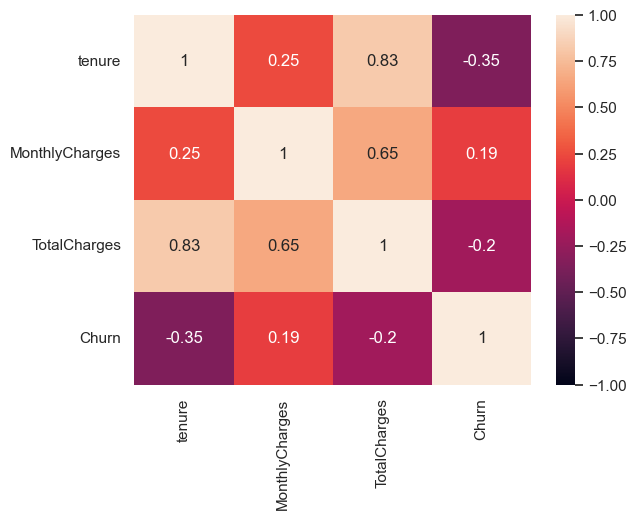

In [41]:
# visualize correlation matrix for numerical variables
df_corr = df.loc[:,['tenure', 
                               'MonthlyCharges', 
                               'TotalCharges', 
                               'Churn']].corr()
sns.heatmap(df_corr, vmin=-1, vmax=1, annot=True);

For logistic regression, the features should not be highly correlated with each other. The variables tenure and TotalCharges have a high correlation of 0.83. Moving forward, a PCA will be applied to address this and potentially reduce redundancy.

In [43]:
# Calculation of the correlation coefficients of the numerical features in relation to the target variable.
df_corr['Churn'].sort_values(ascending = False)

Churn             1.000000
MonthlyCharges    0.193356
TotalCharges     -0.198324
tenure           -0.352229
Name: Churn, dtype: float64

MonthlyCharges shows a moderate correlation with churn, indicating that the higher the monthly costs, the greater the likelihood that a customer will churn. Tenure, on the other hand, suggests that the longer a customer has been with the company, the lower the likelihood of churn. TotalCharges also exhibits a negative correlation, which may seem contradictory. However, tenure and TotalCharges are positively correlated, as customers who stay longer tend to accumulate higher total charges.

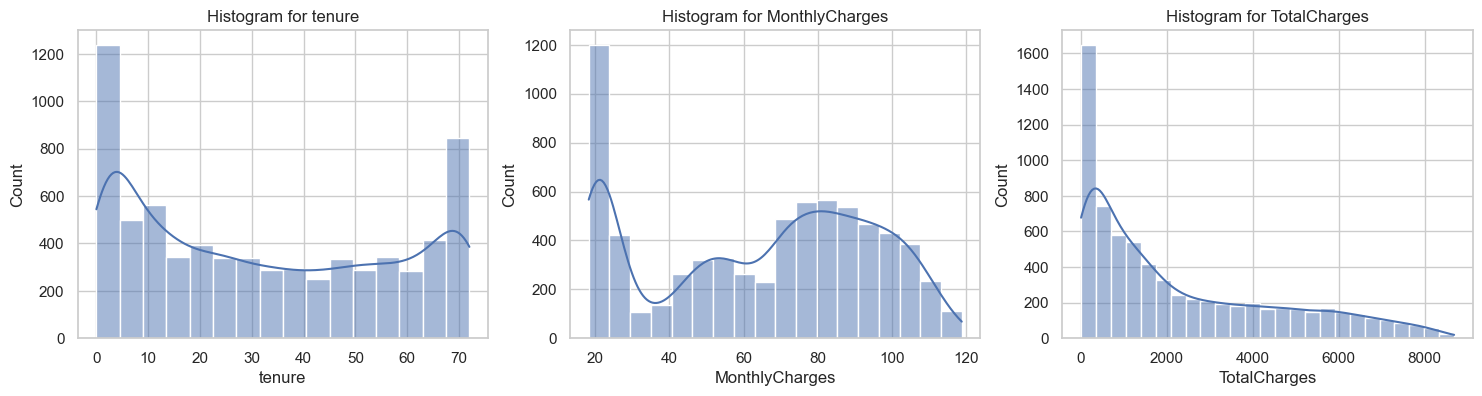

In [45]:
# Checking distributions
# Create Subplots (3 Subplots for kdeplots)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

# Define columns to plot
columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Plotting kdeplots for each column
for i, col in enumerate(columns):
    sns.histplot(df[col], kde=True, ax=ax[i])
    ax[i].set_title('Histogram for {}'.format(col))

The variables are not normally distributed and the features tenure and MonthlyCharges seem to show a bimodal distribution and the column TotalCharges is rightly skewed. To better understand the distributions, the variables will be visualized separately for the "Churn" and "No Churn" categories.

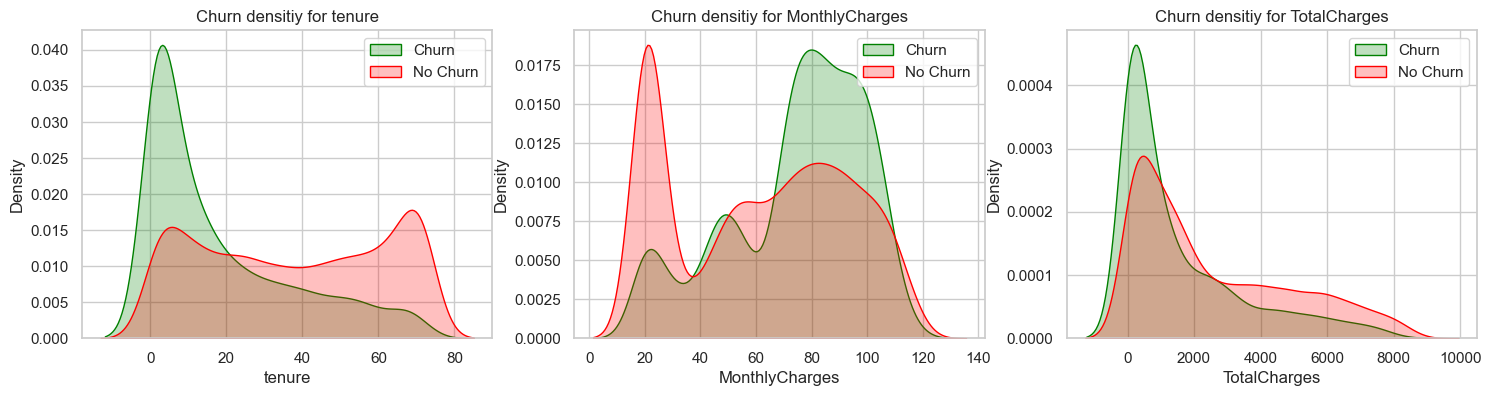

In [47]:
# Create Subplots (3 Subplots for kdeplots)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

# Define columns to plot
columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Plotting kdeplots for each column
for i, col in enumerate(columns):
    sns.kdeplot(df[col][df.Churn == 1], color="green", shade=True, ax=ax[i])
    sns.kdeplot(df[col][df.Churn == 0], color="red", shade=True, ax=ax[i])
    ax[i].set_title('Churn densitiy for {}'.format(col))
    ax[i].legend(['Churn', 'No Churn'])

Dividing the numerical variables into different categories can help gain better insights into potential patterns or anomalies in churn behavior.

In [49]:
# Create bins for tenure, MonthlyCharges and TotalCharges
df_bins = df.copy()

df_bins['tenure_bins'] = pd.cut(df_bins['tenure'], 
                                     bins= [0, 10, 20, 30, 40, 50, 60, 70, 80], 
                                     labels=[0, 10, 20, 30, 40, 50, 60, 70],
                                    include_lowest=True)

df_bins['monthlycharges_bins'] = pd.cut(df_bins['MonthlyCharges'], 
                                     bins= [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 
                                     labels=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
                                    include_lowest=True)

df_bins['totalcharges_bins'] = pd.cut(df_bins['TotalCharges'], 
                                     bins= [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], 
                                     labels=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000],
                                    include_lowest=True)

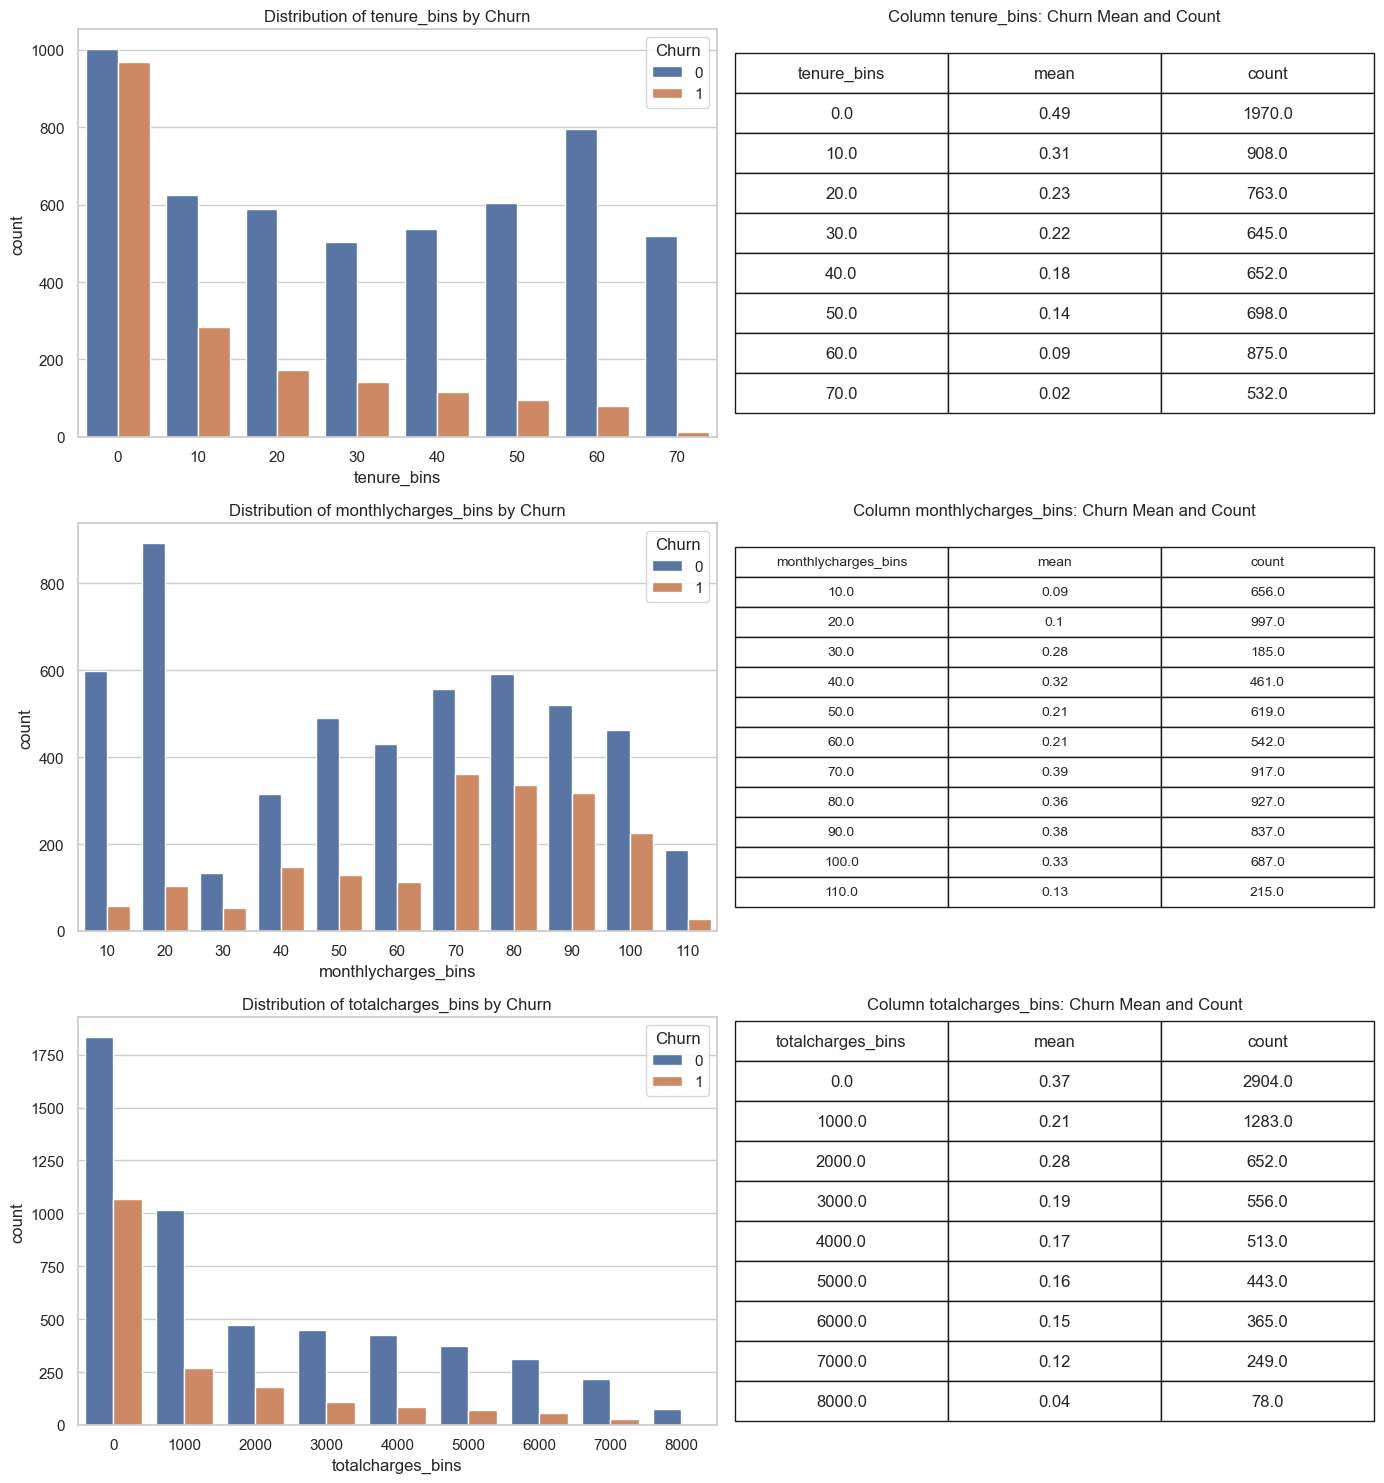

In [51]:
# Create aggregated DataFrames
tenure_agg = df_bins.groupby('tenure_bins', observed=False)['Churn'].agg(['mean', 'count']).reset_index()
monthlycharges_agg = df_bins.groupby('monthlycharges_bins', observed=False)['Churn'].agg(['mean', 'count']).reset_index()
totalcharges_agg = df_bins.groupby('totalcharges_bins', observed=False)['Churn'].agg(['mean', 'count']).reset_index()

# Round values in columns 'mean'
tenure_agg['mean'] = round(tenure_agg['mean'], 2)
monthlycharges_agg['mean'] = round(monthlycharges_agg['mean'], 2)
totalcharges_agg['mean'] = round(totalcharges_agg['mean'], 2)

# Create Subplots (6 Subplots: 3 for countplots, 3 for the tables)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))

# Define columns to plot
columns = ['tenure_bins', 'monthlycharges_bins', 'totalcharges_bins']

# Plotting Countplot for each column
for i, col in enumerate(columns):
    sns.countplot(x=col, hue='Churn', data=df_bins, ax=ax[i, 0])
    ax[i, 0].set_title('Distribution of {} by Churn'.format(col))
    
# Plotting tables for each aggregated DataFrame
for i, col in enumerate(columns):
    ax[i, 1].axis('tight')
    ax[i, 1].axis('off')
    ax[i, 1].set_title('Column {}: Churn Mean and Count'.format(col))
    #tenure_table = ax[i, 1].table(cellText=col.values, colLabels=col.columns, cellLoc='center', loc='center')
    
tenure_table = ax[0, 1].table(cellText=tenure_agg.values, colLabels=tenure_agg.columns, cellLoc='center', loc='center')
tenure_table.scale(1, 2) 

monthlycharges_table = ax[1, 1].table(cellText=monthlycharges_agg.values, colLabels=monthlycharges_agg.columns, cellLoc='center', loc='center')
monthlycharges_table.scale(1, 1.5) 

totalcharges_table = ax[2, 1].table(cellText=totalcharges_agg.values, colLabels=totalcharges_agg.columns, cellLoc='center', loc='center')
totalcharges_table.scale(1, 2)

plt.tight_layout()
plt.show()

The churn rate is particularly high among customers who have been with the company for ten months or less. The longer customers stay with the company, the less likely they are to leave. Additionally, customers with monthly charges ranging from 70 to 100 show a higher churn rate compared to other groups. For customers with TotalCharges less than 1000, it is more likely that they will churn.

# 3.4 EDA categorical Features

In [53]:
# basic statistics for categorical features
df[cat_cols].describe(include='object').T

,count,unique,top,freq
gender,7043,2,male,3555
Partner,7043,2,no,3641
Dependents,7043,2,no,4933
PhoneService,7043,2,yes,6361
MultipleLines,7043,3,no,3390
InternetService,7043,3,fiber_optic,3096
OnlineSecurity,7043,3,no,3498
OnlineBackup,7043,3,no,3088
DeviceProtection,7043,3,no,3095
TechSupport,7043,3,no,3473


The variables gender, Partner, Dependents, PhoneService, and PaperlessBilling are binary. The remaining variables have three to four unique values. In the following section, we will take a closer look at the unique values and their distribution.

In [55]:
for col in cat_cols:
    print(f'{col} unique: {df[col].unique()}')
    print(f'{col} nunique: {df[col].nunique()}')
    print(f'{col} value counts: {df[col].value_counts()}\n')
    print('-'*40, '\n')

gender unique: ['female' 'male']
gender nunique: 2
gender value counts: gender
male      3555
female    3488
Name: count, dtype: int64

---------------------------------------- 

SeniorCitizen unique: [0 1]
SeniorCitizen nunique: 2
SeniorCitizen value counts: SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

---------------------------------------- 

Partner unique: ['yes' 'no']
Partner nunique: 2
Partner value counts: Partner
no     3641
yes    3402
Name: count, dtype: int64

---------------------------------------- 

Dependents unique: ['no' 'yes']
Dependents nunique: 2
Dependents value counts: Dependents
no     4933
yes    2110
Name: count, dtype: int64

---------------------------------------- 

PhoneService unique: ['no' 'yes']
PhoneService nunique: 2
PhoneService value counts: PhoneService
yes    6361
no      682
Name: count, dtype: int64

---------------------------------------- 

MultipleLines unique: ['no_phone_service' 'no' 'yes']
MultipleLines nunique: 3
MultipleL

1,526 customers do not use the internet service. These customers have the value "no_internet_service" in the columns OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies. In the following section, we will check whether these values are consistent and only appear for customers who truly do not have internet service.

Similarly, all customers without phone service, in total 682, have the value "no_phone_service" in the MultipleLines column. We will also check whether this data is consistent.

In [57]:
mask_no_internet_service = (df.loc[:, 'InternetService'] == 'no')\
& (df.loc[:, 'OnlineSecurity'] == 'no_internet_service')\
& (df.loc[:, 'OnlineBackup'] == 'no_internet_service')\
& (df.loc[:, 'DeviceProtection'] == 'no_internet_service')\
& (df.loc[:, 'TechSupport'] == 'no_internet_service')\
& (df.loc[:, 'StreamingTV'] == 'no_internet_service')\
& (df.loc[:, 'StreamingMovies'] == 'no_internet_service')\

df.loc[mask_no_internet_service,['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].count()

OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64

In [59]:
mask_no_phone_service = (df.loc[:, 'PhoneService'] == 'no')\
& (df.loc[:, 'MultipleLines'] == 'no_phone_service')

df.loc[mask_no_phone_service, ['PhoneService', 'MultipleLines']].count()

PhoneService     682
MultipleLines    682
dtype: int64

The data is consistent. As part of feature engineering, it will later be examined whether this duplicate information leads to multicollinearity.

# 3.5 Feature importance and risk rate

The risk ratio is used to assess the probability of customer churn in relation to specific characteristics or factors and helps identify how strongly different variables influence the risk of churn. The risk ratio allows for comparisons between different customer groups. For example, it can show whether the risk for customers using certain products or services is higher or lower than for other groups. If the risk ratio is greater than 1, it indicates that customers in this group are more likely to churn. Conversely, if it is less than 1, the likelihood of churn is lower. A high risk ratio for a specific variable may indicate that this variable is significant for the model.

In [61]:
# Calculate risk ratio
churn_rate = df['Churn'].mean()

for col in cat_cols:
    df_temp = df.groupby(col)['Churn'].agg(['mean', 'count'])
    df_temp['risk ratio'] = df_temp['mean'] / churn_rate
    display(df_temp)

,mean,count,risk ratio
gender,,,
female,0.269209,3488,1.014466
male,0.261603,3555,0.985807


,mean,count,risk ratio
SeniorCitizen,,,
0,0.236062,5901,0.889557
1,0.416813,1142,1.570686


,mean,count,risk ratio
Partner,,,
no,0.329580,3641,1.241964
yes,0.196649,3402,0.741038


,mean,count,risk ratio
Dependents,,,
no,0.312791,4933,1.178700
yes,0.154502,2110,0.582215


,mean,count,risk ratio
PhoneService,,,
no,0.249267,682,0.939319
yes,0.267096,6361,1.006506


,mean,count,risk ratio
MultipleLines,,,
no,0.250442,3390,0.943749
no_phone_service,0.249267,682,0.939319
yes,0.286099,2971,1.078114


,mean,count,risk ratio
InternetService,,,
dsl,0.189591,2421,0.714441
fiber_optic,0.418928,3096,1.578656
no,0.074050,1526,0.279044


,mean,count,risk ratio
OnlineSecurity,,,
no,0.417667,3498,1.573906
no_internet_service,0.074050,1526,0.279044
yes,0.146112,2019,0.550597


,mean,count,risk ratio
OnlineBackup,,,
no,0.399288,3088,1.504645
no_internet_service,0.074050,1526,0.279044
yes,0.215315,2429,0.811377


,mean,count,risk ratio
DeviceProtection,,,
no,0.391276,3095,1.474456
no_internet_service,0.074050,1526,0.279044
yes,0.225021,2422,0.847951


,mean,count,risk ratio
TechSupport,,,
no,0.416355,3473,1.568960
no_internet_service,0.074050,1526,0.279044
yes,0.151663,2044,0.571517


,mean,count,risk ratio
StreamingTV,,,
no,0.335231,2810,1.263261
no_internet_service,0.074050,1526,0.279044
yes,0.300702,2707,1.133143


,mean,count,risk ratio
StreamingMovies,,,
no,0.336804,2785,1.269188
no_internet_service,0.074050,1526,0.279044
yes,0.299414,2732,1.128291


,mean,count,risk ratio
Contract,,,
month_to_month,0.427097,3875,1.609440
one_year,0.112695,1473,0.424672
two_year,0.028319,1695,0.106714


,mean,count,risk ratio
PaperlessBilling,,,
no,0.163301,2872,0.615371
yes,0.335651,4171,1.264842


,mean,count,risk ratio
PaymentMethod,,,
bank_transfer_(automatic),0.167098,1544,0.629681
credit_card_(automatic),0.152431,1522,0.574410
electronic_check,0.452854,2365,1.706502
mailed_check,0.191067,1612,0.720003


The following customer groups exhibit a particularly high or low risk ratio, indicating that they are significant for the model.The likelihood of churn among customers

- using the payment method 'electronic check' is 70% higher compared to the overall churn rate.
- with a "month to month" contract is 60% higher than the overall churn rate.
- using "fiber optic" service is 57% higher than the overall churn rate.


- with a two-year contract is 90% lower than the overall churn rate.
- with dependents is 40% lower than the overall churn rate.
- with a partner is 24% lower than the overall churn rate.

# 4. Train-Test-Split

Split the data into training and testing data 80:20

In [63]:
# perform train-test-split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.shape, df_test.shape

((5634, 21), (1409, 21))

In [65]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['Churn']
y_test = df_test['Churn']

# The variable 'customerID' is not a categorical variable but rather an identifier for the customer. 
# Therefore, it will be removed from the dataset.
X_train = df_train.drop(['customerID', 'Churn'], axis=1)
X_test = df_test.drop(['customerID', 'Churn'], axis=1)

# 5. Feature Engineering

Use encoding techniques and feature scaling to prepare the data for modeling.

Steps:

- Encoding categorical variables: Apply one-hot encoding for nominal features.
- Scaling: Standardize the numerical features to have a mean of 0 and a standard deviation of 1.

In [67]:
# Define Function for Label encoding
def label_encoding(df, le_columns):
    """Encodes binary categorical variables into 0s and 1s."""
    df = df.copy()
    for col in le_columns:
        if col == 'gender':
            df[col] = df[col].map({'male': 0,'female': 1})
        else:
            df[col] = df[col].map({'no_phone_service': 0, 'no_internet_service': 0, 'no': 0,'yes': 1})
    
    return df

# Define Function for Feature scaling
def scale_features(X_train, X_test, num_columns):
    """Scales numerical features using StandardScaler."""
    scaler = StandardScaler()
    X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
    X_test[num_columns] = scaler.transform(X_test[num_columns])
    
    return X_train, X_test

# Apply Scaling, Label encoding and One Hot Encoding
def engineer_features(X_train, X_test, ohe_columns, num_columns, le_columns):
    """Applies one-hot encoding to the features."""
    # apply function above for label encoding
    X_train = label_encoding(X_train, le_columns)
    X_test = label_encoding(X_test, le_columns)

    # set up pipeline
    ohe = OneHotEncoder(sparse_output=False)
    encoder = ColumnTransformer([('OHE',ohe, ohe_columns)], remainder='passthrough')

    # fit encoder
    encoder.fit(X_train)

    # restore column names for final DataFrames
    ohe_names = encoder.named_transformers_['OHE'].get_feature_names_out(ohe_columns)
    remaining_names = [col for col in X_train.columns if col not in ohe_columns]

    # apply encoding and create DataFrames
    X_train = pd.DataFrame(encoder.transform(X_train), columns = list(ohe_names) + list(remaining_names))
    X_test = pd.DataFrame(encoder.transform(X_test), columns = list(ohe_names) + list(remaining_names))

    # apply feature scaling
    X_train, X_test = scale_features(X_train, X_test, num_columns)
    
    return X_train, X_test

In [69]:
# Define columns for label encoding, one-hot-encoding and scaling
ohe_columns=['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
           'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
le_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Apply function for feature engineering
X_train_pre, X_test_pre = engineer_features(X_train, X_test, ohe_columns, num_cols, le_columns)

Visualize the correlation matrix to highlight any potential strong correlations among the new features.

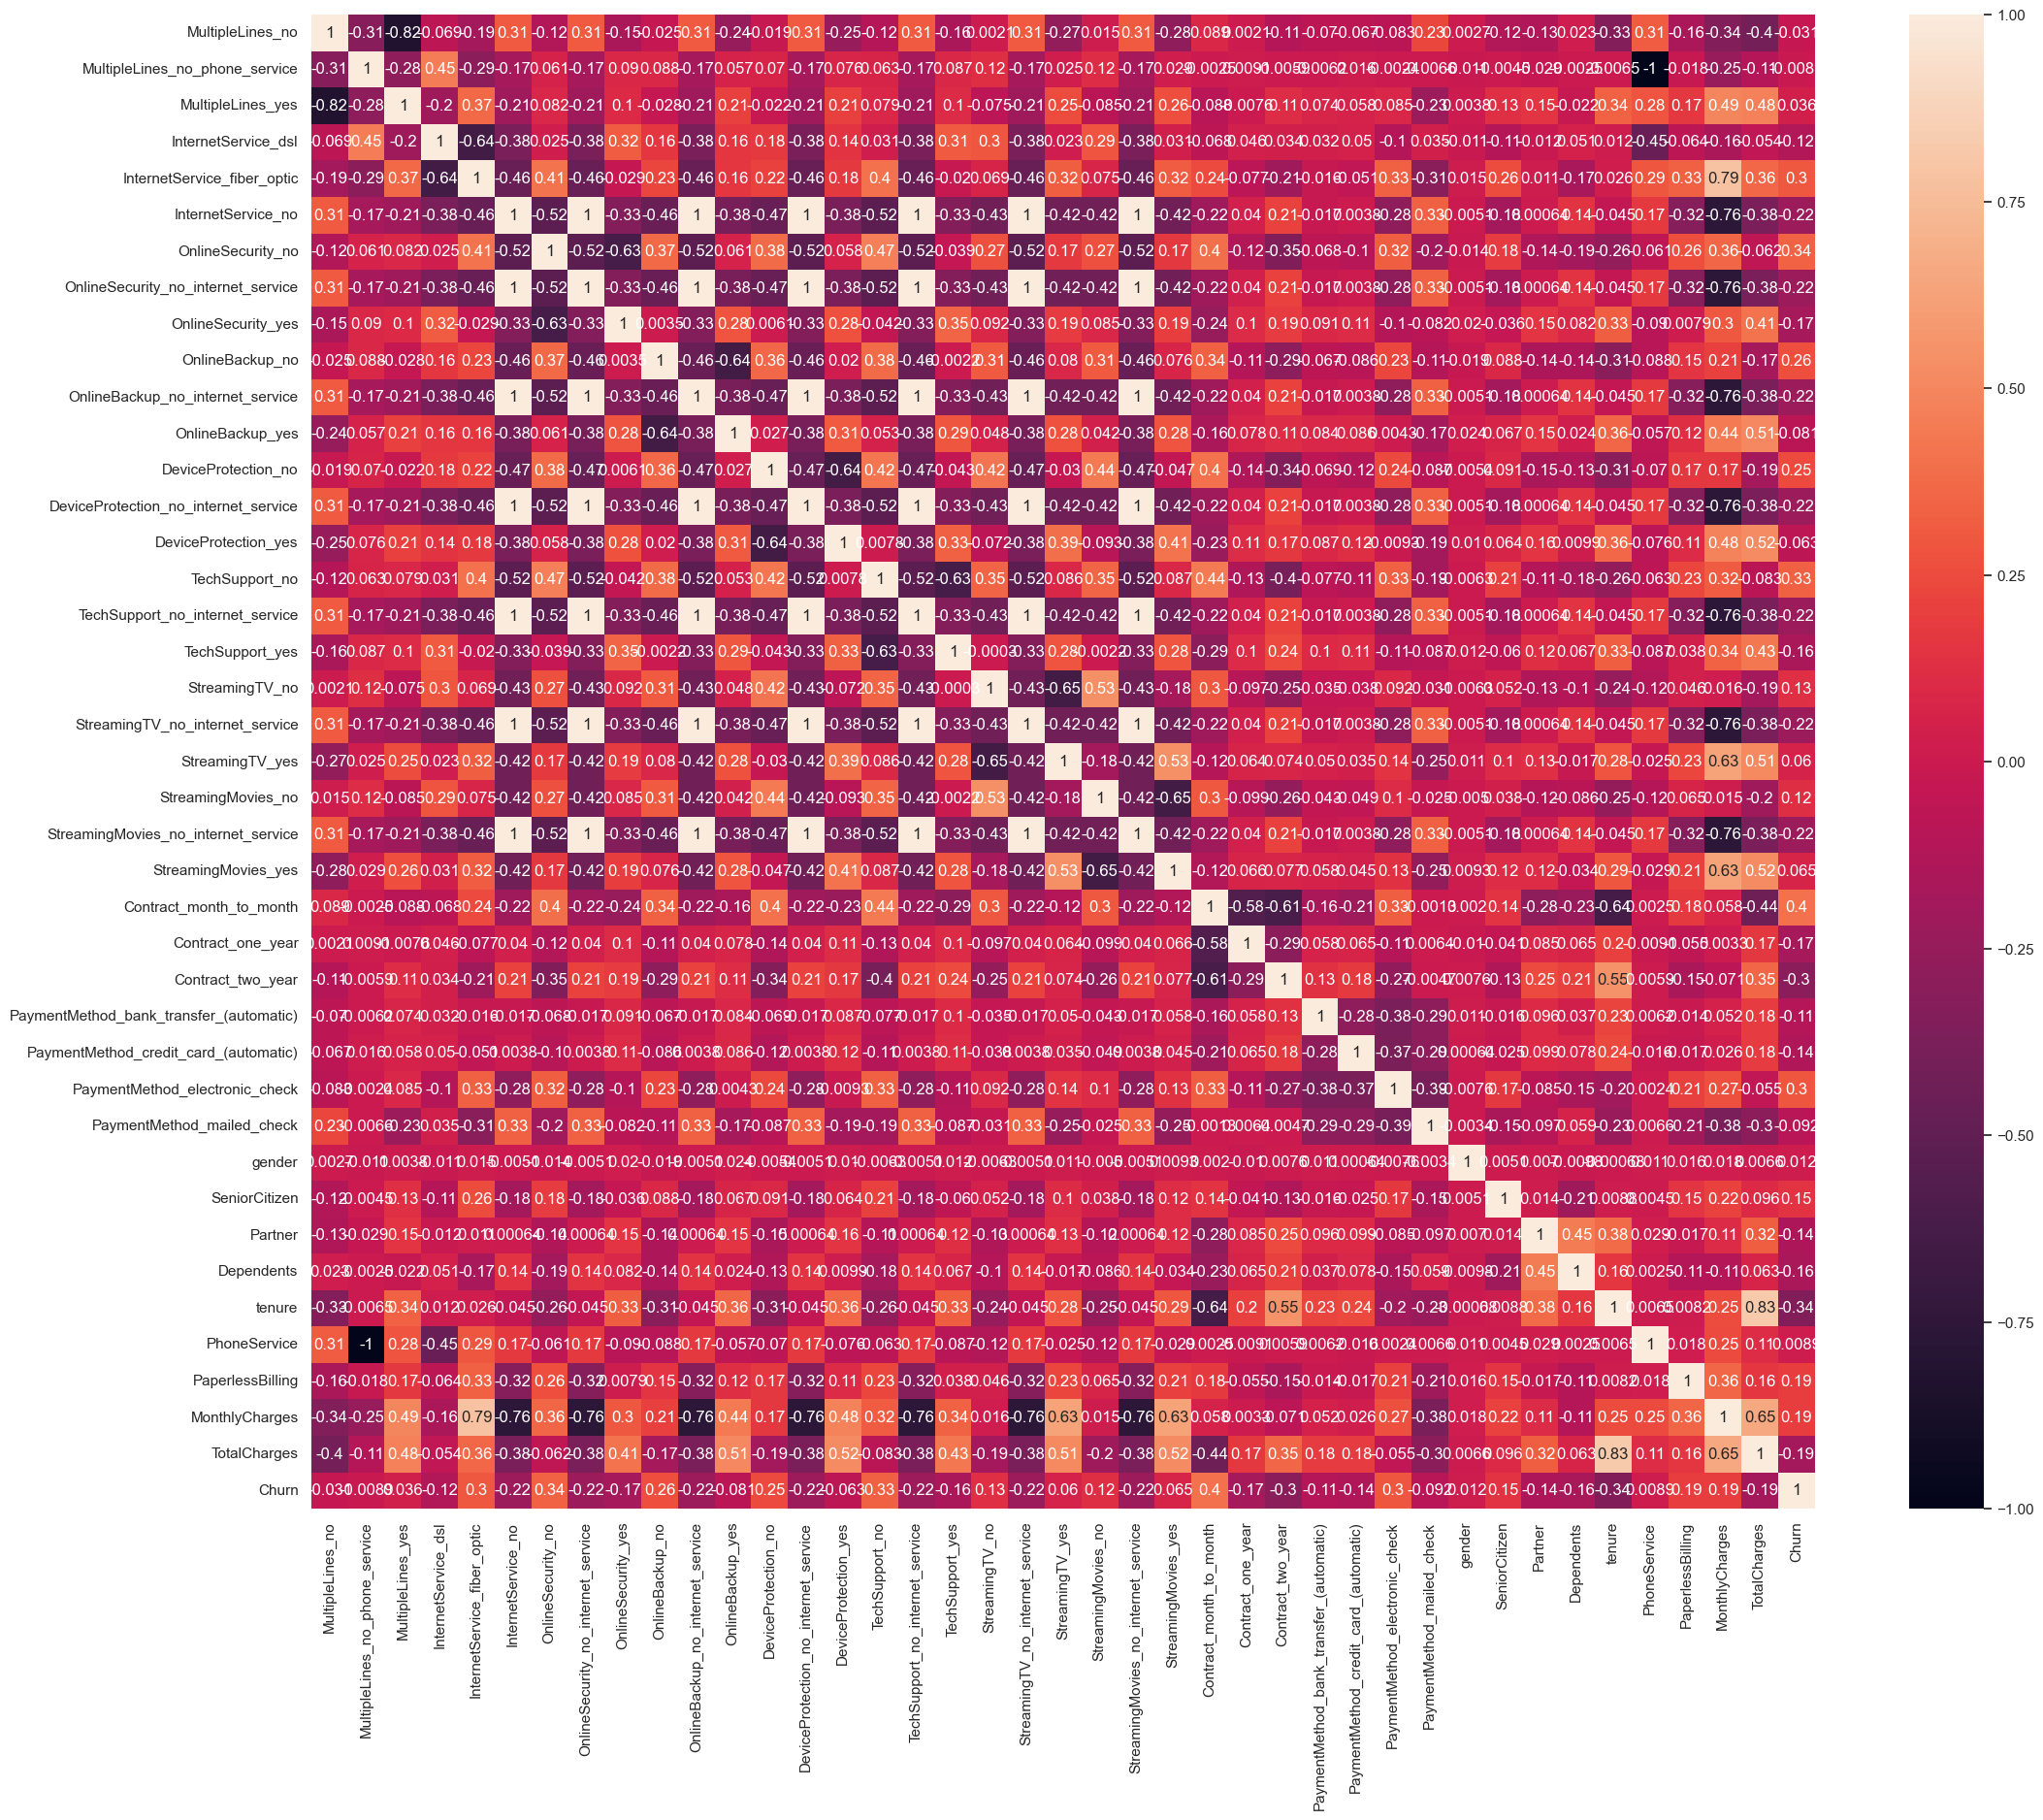

In [71]:
df_corr = X_train_pre.copy()
df_corr['Churn'] = y_train

plt.figure(figsize=(25, 20))
sns.heatmap(df_corr.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

Due to one-hot encoding, the variables OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies have generated new features: OnlineBackup_no_internet_service, DeviceProtection_no_internet_service, TechSupport_no_internet_service, StreamingTV_no_internet_service, and StreamingMovies_no_internet_service. The 'No Internet Service' information is therefore duplicated across multiple features in the dataset, creating redundancy.

As shown in the correlation matrix, these new variables have a perfect correlation with the InternetService_no variable. The 'No Internet Service' information is already contained in the original InternetService variable. Similarly, all customers without phone service have the value "no_phone_service" in the MultipleLines column. To avoid redundant information and multicollinearity, the values in these columns should be encoded as binary variables: 'no_phone_service': 0, 'no_internet_service': 0, 'no': 0, 'yes': 1.

In [73]:
# Define new columns for label encoding, one-hot-encoding and scaling
ohe_columns= ['InternetService', 'Contract', 'PaymentMethod']
le_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Apply function for feature engineering
X_train_pre_2, X_test_pre_2 = engineer_features(X_train, X_test, ohe_columns, num_cols, le_columns)

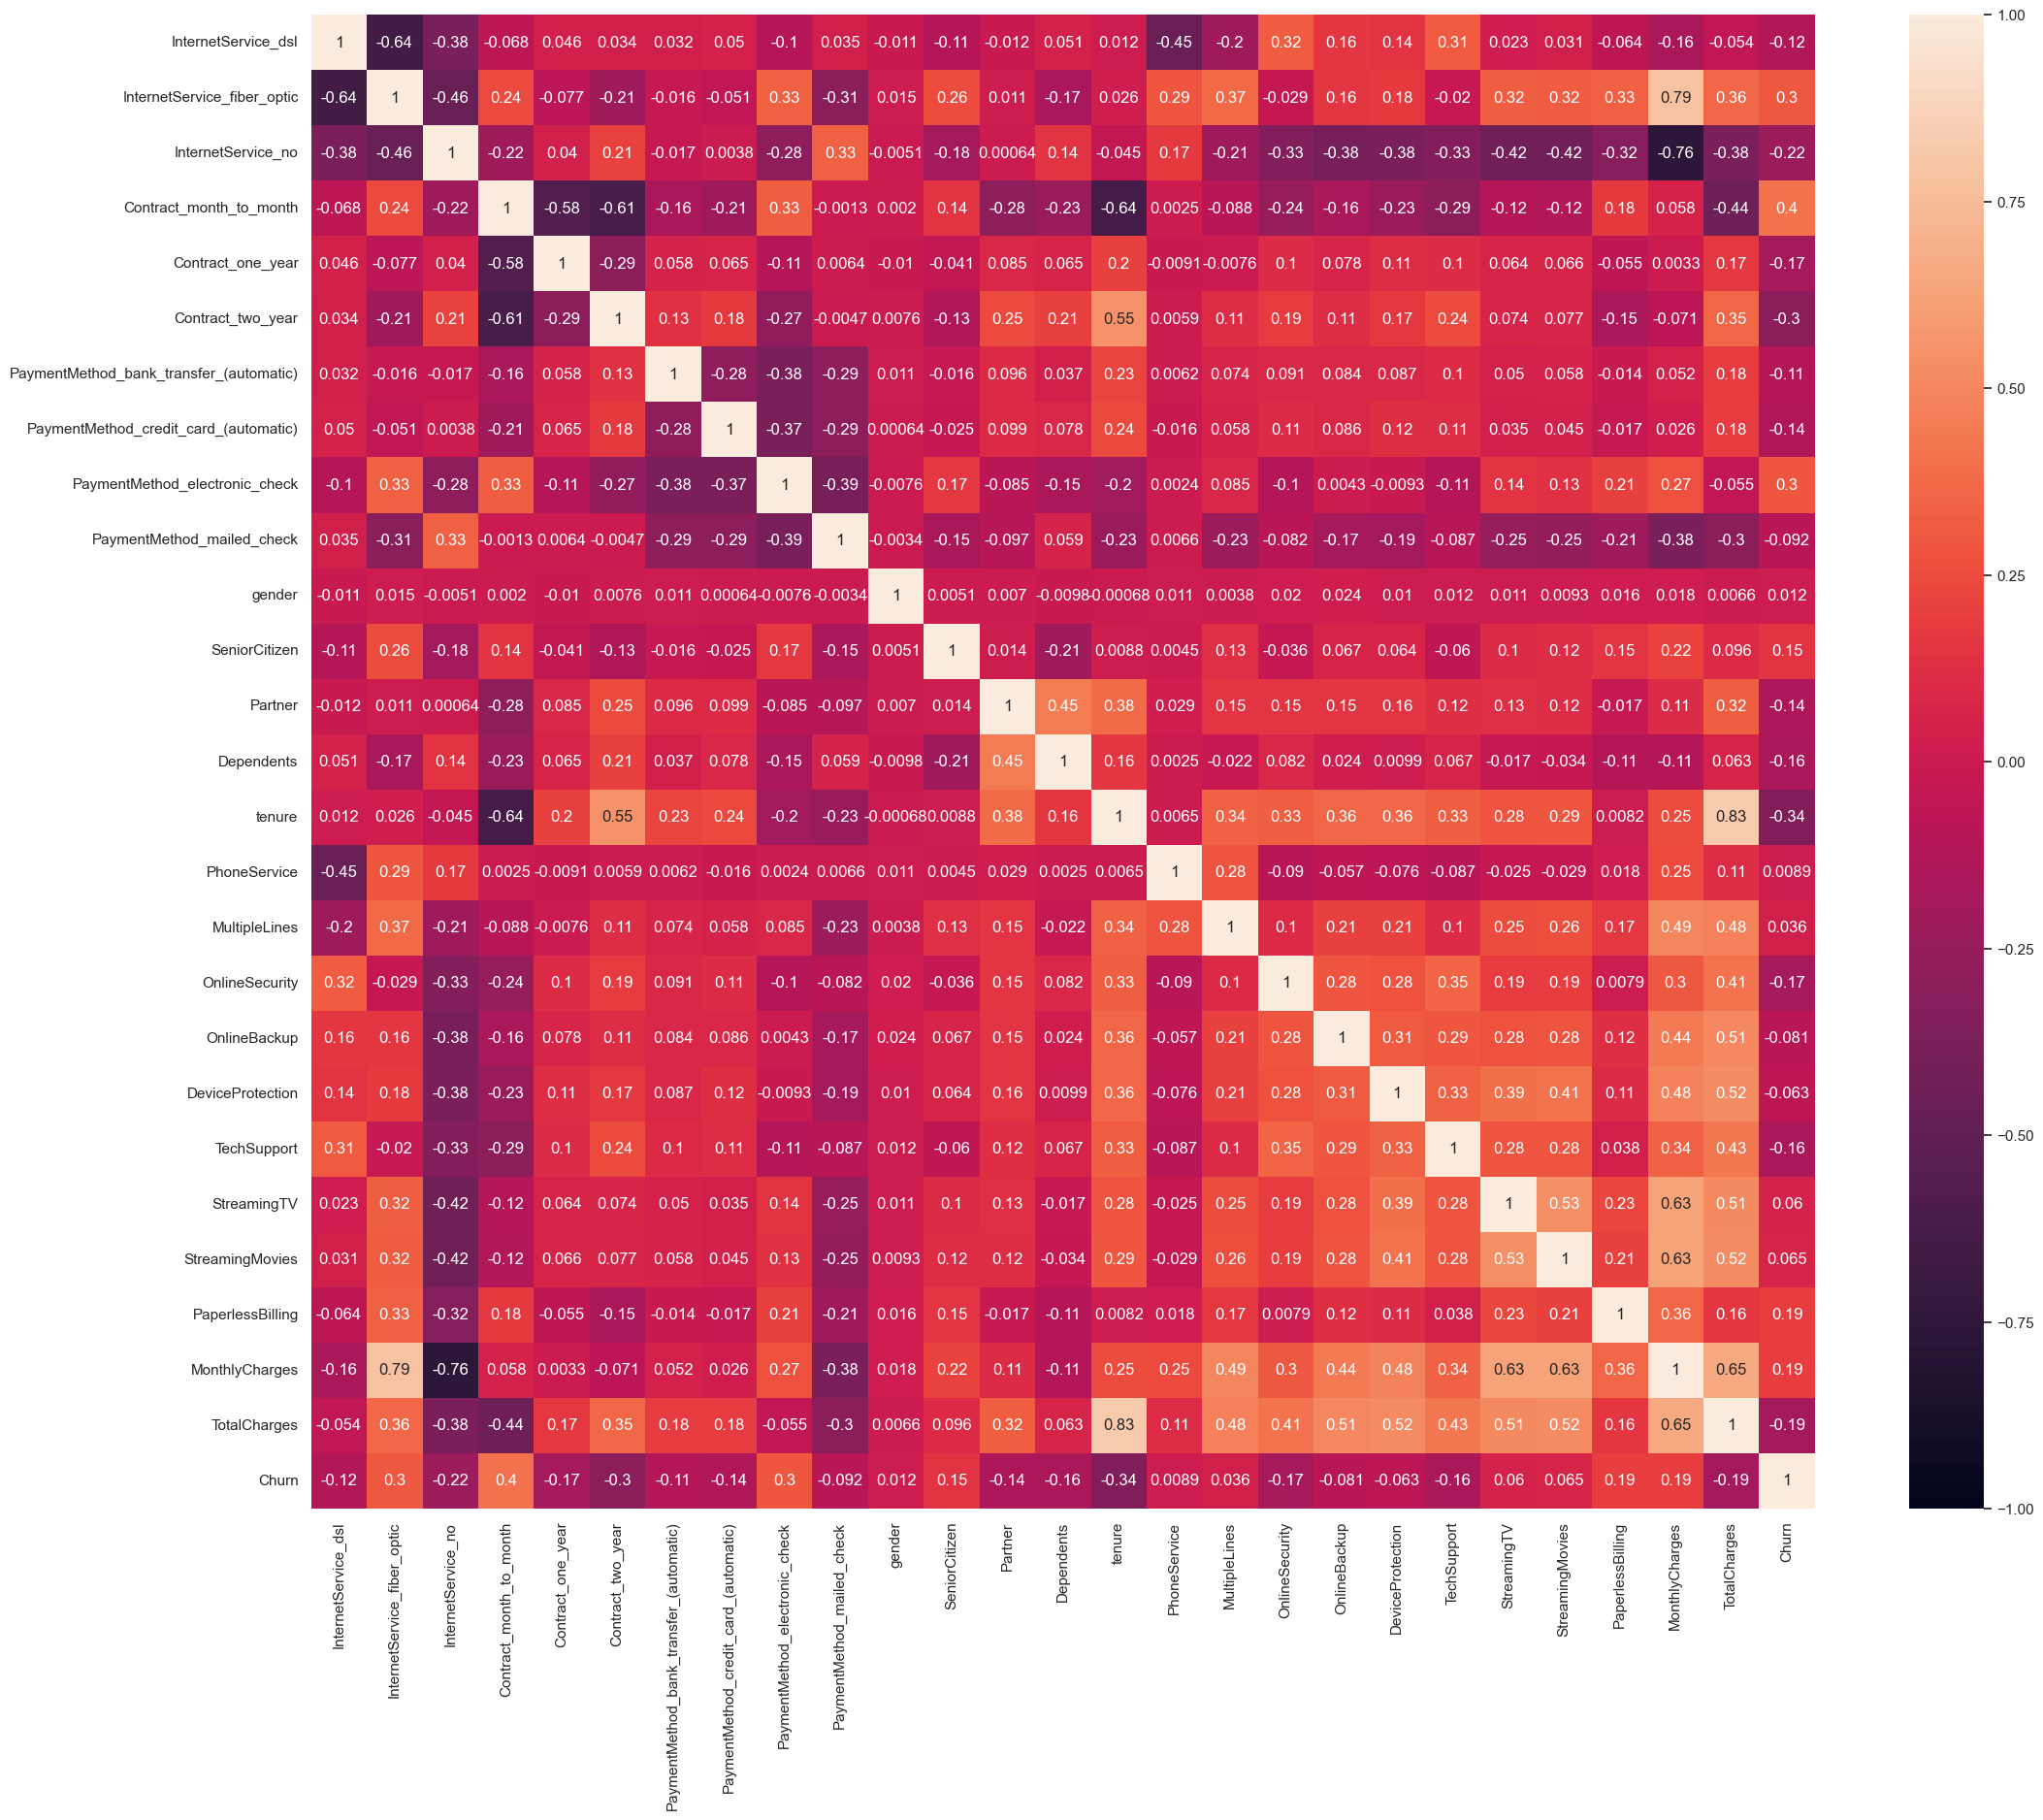

In [75]:
df_corr_2 = X_train_pre_2.copy()
df_corr_2['Churn'] = y_train

plt.figure(figsize=(25, 20))
sns.heatmap(df_corr_2.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

# 6. Train the model

In [77]:
# Define Function to evaluate the model performance
df_eval = pd.DataFrame()

def eval_model(model, model_name, X_train, y_train, X_test, y_test, cv_logreg):
    """
    Evaluates a given model's performance on the test data and computes various evaluation metrics.
    
    Parameters:
    - model: The machine learning model to be evaluated.
    - model_name: The name of the model, used for display purposes.
    - X_train: The training feature data.
    - y_train: The training target data.
    - X_test: The testing feature data.
    - y_test: The testing target data.
    - cv_logreg: Cross-validation scores for recall to calculate standard deviation.
    
    The function prints the classification report, confusion matrix, and stores performance metrics 
    (precision, recall, F1 score, accuracy, ROC-AUC, and cross-validation recall statistics) in a 
    DataFrame for further analysis.
    """
    global df_eval

    print(model_name, ':\n')
    
    model.fit(X_train, y_train)
    
    y_test_pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)

    roc_auc = round(roc_auc_score(y_test, y_test_pred_proba[:, 1]), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred), 4)
    f1 = round(f1_score(y_test, y_pred), 4)
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    recall_cv_stdev = round(stdev(cv_logreg), 4)
 
    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    # Plotten der Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

    # Hinzufügen von Achsenbeschriftungen
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Hinzufügen von Titel und Achsenbezeichnungen
    plt.title('Confusion Matrix')
    plt.show()    
    
    df_temp = pd.DataFrame({
    'Model': [model_name],
    'Precision': [precision],
    'Recall': [recall],
    'F1': [f1],
    'Accuracy': [accuracy],
    'ROC-AUC': [roc_auc],
    'Avg Recall CV': [round(cv_logreg.mean(), 4)],
    'Stdev Recall CV': [recall_cv_stdev]
})
    
    df_eval = pd.concat([df_eval, df_temp], ignore_index=True, sort=False)
    display(df_eval)
    print('-'*50,'\n')

Build a simple Baselinemodel

In [79]:
model_lr = LogisticRegression(random_state=42)

cv_logreg = cross_val_score(model_lr,
                            X_train_pre,
                            y_train,
                            scoring="recall",
                            cv=5)
print('recall-score from cross validation:', cv_logreg.mean())

recall-score from cross validation: 0.5421070234113713


LogisticRegression :

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



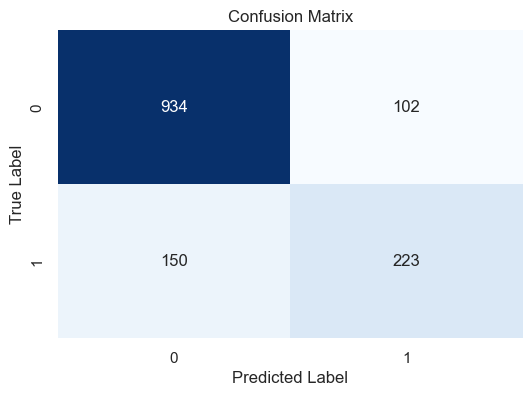

,Model,Precision,Recall,F1,Accuracy,ROC-AUC,Avg Recall CV,Stdev Recall CV
0,LogisticRegression,0.6862,0.5979,0.639,0.8211,0.8623,0.5421,0.0335


-------------------------------------------------- 



In [81]:
eval_model(model_lr, 'LogisticRegression', X_train_pre, y_train, X_test_pre, y_test, cv_logreg)

Due to multicollinearity, the columns OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies were encoded as binary variables. The next step will be to assess whether this adjustment improves model performance.

In [83]:
model_lr_2 = LogisticRegression(random_state=42)

cv_logreg = cross_val_score(model_lr_2,
                            X_train_pre_2,
                            y_train,
                            scoring="recall",
                            cv=5)
print('recall-score from cross validation:', cv_logreg.mean())

recall-score from cross validation: 0.53809364548495


LogisticRegression2 :

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



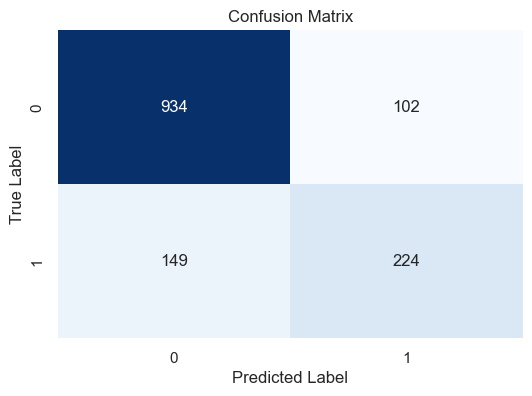

,Model,Precision,Recall,F1,Accuracy,ROC-AUC,Avg Recall CV,Stdev Recall CV
0,LogisticRegression,0.6862,0.5979,0.6390,0.8211,0.8623,0.5421,0.0335
1,LogisticRegression2,0.6871,0.6005,0.6409,0.8219,0.8623,0.5381,0.0387


-------------------------------------------------- 



In [85]:
eval_model(model_lr_2, 'LogisticRegression2', X_train_pre_2, y_train, X_test_pre_2, y_test, cv_logreg)

The adjustments contributed to a slight improvement in the model.

# 7. PCA

In logistic regression, features should have low intercorrelation. The variables tenure and TotalCharges, however, show a high correlation of 0.83. To address this and reduce potential redundancy, PCA will be applied in the next steps.

In [87]:
# Select only the relevant columns for PCA
pca_columns_train = X_train_pre_2[['tenure', 'TotalCharges']]
pca_columns_test = X_test_pre_2[['tenure', 'TotalCharges']]

 # Perform PCA
pca = PCA(n_components=1)  # Specify the number of principal components
pca_results_train = pca.fit_transform(pca_columns_train)
pca_results_test = pca.transform(pca_columns_test)

# Create a new DataFrame for the PCA results of the training data
pca_df_train = pd.DataFrame(pca_results_train, columns=['PC1'])

# Create a new DataFrame for the PCA results of the test data
pca_df_test = pd.DataFrame(pca_results_test, columns=['PC1'])

# Add the remaining columns back
X_train_pca = pd.concat([pca_df_train, X_train_pre_2.drop(['tenure', 'TotalCharges'], axis=1).reset_index(drop=True)], axis=1)
X_test_pca = pd.concat([pca_df_test, X_test_pre_2.drop(['tenure', 'TotalCharges'], axis=1).reset_index(drop=True)], axis=1)

In [89]:
model_lr_pca = LogisticRegression(random_state=42)

cv_logreg = cross_val_score(model_lr_pca,
                            X_train_pca,
                            y_train,
                            scoring="recall",
                            cv=5)
print('recall-score from cross validation:', cv_logreg.mean())

recall-score from cross validation: 0.5267246376811594


LogisticRegression PCA :

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1036
           1       0.69      0.59      0.64       373

    accuracy                           0.82      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



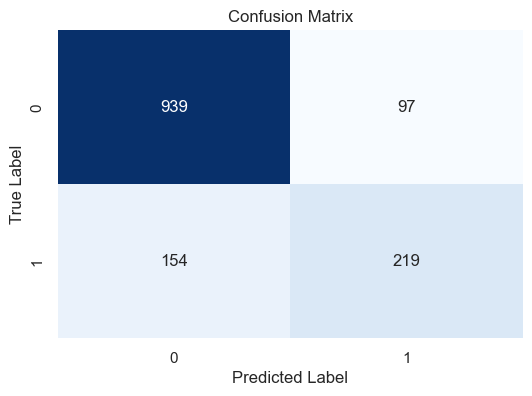

,Model,Precision,Recall,F1,Accuracy,ROC-AUC,Avg Recall CV,Stdev Recall CV
0,LogisticRegression,0.6862,0.5979,0.6390,0.8211,0.8623,0.5421,0.0335
1,LogisticRegression2,0.6871,0.6005,0.6409,0.8219,0.8623,0.5381,0.0387
2,LogisticRegression PCA,0.6930,0.5871,0.6357,0.8219,0.8580,0.5267,0.0342


-------------------------------------------------- 



In [91]:
eval_model(model_lr_pca, 'LogisticRegression PCA', X_train_pca, y_train, X_test_pca, y_test, cv_logreg)

The application of PCA did not lead to an improvement in model performance in this case. While the precision score slightly increased, the other scores, in turn, worsened.

# 8. Finding the best regularization parameter

The regularization in logistic regression aims to strike a balance between two objectives:

- Minimizing the difference between predicted and actual target values: This corresponds to minimizing the error or maximizing the model's accuracy with respect to the actual target values. Logistic regression attempts to maximize prediction accuracy by optimizing the parameters to minimize the log-loss function (the sum of the negative log-likelihoods of the predicted classes).
- Minimizing the sum of the squared weights: This is the regularization term (also referred to as L2 regularization or shrinkage penalty), which prevents large weight values. This means that the model would be "penalized" for large increases. The regularization term is proportional to the sum of the squared weights and helps to avoid overfitting by reducing the model's complexity. A model with large weights tends to oscillate and fit too closely to the training data, which reduces its ability to generalize to new data.

In regularized logistic regression (such as Ridge regression), the objective function is augmented with a regularization term, so it pursues a combination of both goals. The C parameter in logistic regression controls the balance between these two objectives.

To ensure that the difference between the parameters is meaningful, it should not be linear, but instead test progressively larger gaps between parameter values.

LogisticRegression with C=0.001 :

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1036
           1       0.78      0.20      0.32       373

    accuracy                           0.77      1409
   macro avg       0.78      0.59      0.59      1409
weighted avg       0.78      0.77      0.72      1409



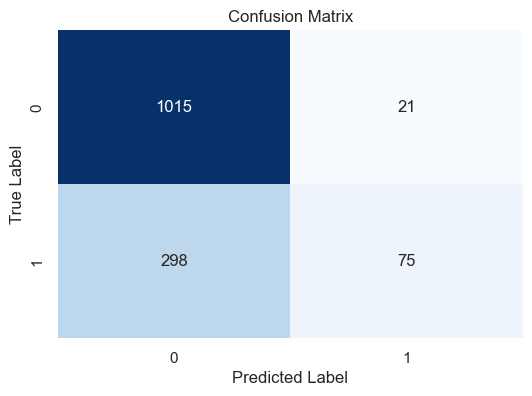

,Model,Precision,Recall,F1,Accuracy,ROC-AUC,Avg Recall CV,Stdev Recall CV
0,LogisticRegression,0.6862,0.5979,0.6390,0.8211,0.8623,0.5421,0.0335
1,LogisticRegression2,0.6871,0.6005,0.6409,0.8219,0.8623,0.5381,0.0387
2,LogisticRegression PCA,0.6930,0.5871,0.6357,0.8219,0.8580,0.5267,0.0342
3,LogisticRegression with C=0.001,0.7812,0.2011,0.3198,0.7736,0.8578,0.5381,0.0387


-------------------------------------------------- 

LogisticRegression with C=0.01 :



In [ ]:
# Define C_values
C_values = [0.001, 0.01, 0.1, 1, 2, 4, 8, 16, 32, 63,126, 251, 501, 1000]

for C in C_values:
    
    model = LogisticRegression(C=C, random_state=42)
    
    cv_logreg = cross_val_score(model_lr_2,
                            X_train_pre_2,
                            y_train,
                            scoring="recall",
                            cv=5)
    
    eval_model(LogisticRegression(C=C, random_state=42), f'LogisticRegression with C={C}', X_train_pre_2, y_train, X_test_pre_2, y_test, cv_logreg)

Retaining existing customers is significantly more cost-effective than acquiring new ones. False negative results (when a churn-prone customer is not identified as such) should be avoided, as they are particularly costly. Recall is an important metric for evaluating the model's performance. The regularization parameter at C=2 shows a slight improvement in the recall score, which is why this value is considered the best regularization parameter.

# 9. Check different thresholds

The question is whether the threshold is ideal in every case. Therefore we evaluate the predictions with different thresholds.

Logistic Regression uses a default threshold of 0.5 (50%) for determining predicted categories. Lowering this threshold results in more positive predictions, which increases the True Positive Rate. However, this also lowers precision, as more predicted positives turn out to be false.

In [ ]:
logreg_best_C = LogisticRegression(C=2, random_state=42)

logreg_best_C.fit(X_train_pre_2, y_train)

y_pred_proba = logreg_best_C.predict_proba(X_test_pre_2)[:, 1]

# define thresholds to be tested
thresholds = np.linspace(0, 1, 41)

scores = []

for t in thresholds:
    score = accuracy_score(y_test, y_pred_proba >= t)
    print(f'threshold: {t:.4f}, score: {score:.3f}')
    scores.append(score)

It has been confirmed that the best accuracy score is achieved with a threshold of 0.5, which corresponds to the default threshold for Logistic Regression.

The accuracy score can be misleading in imbalanced datasets because it only measures the proportion of correctly predicted classes out of all predictions, without considering the class distribution. In highly imbalanced datasets, where one class is much more frequent than the other, a model can achieve a high accuracy by simply predicting the most common class, without truly reflecting its performance.

The AUC value for the ROC curve indicates the model's ability to distinguish between classes, regardless of the chosen threshold or class distribution.

# 10. ROC-AUC-Curve for the best model

For Logistic Regression, a threshold of 0.5 (50%) is used by default to determine the predicted categories. Lowering this threshold results in more positive predictions, which increases the recall. However, this also decreases precision, as more of the predicted positive cases are actually false.

In our case, lowering the threshold would result in classifying more customers as churners. This would miss fewer actual churners (improving recall), but it would also increase the number of customers predicted to churn who do not actually intend to (decreasing precision). In the extreme case, with a threshold of 0, all customers would be predicted as churners. While this would identify all actual churners (perfect recall), the precision would be extremely low.

This dynamic can be effectively visualized with the Receiver Operating Characteristic (ROC) curve. The y-axis represents the True Positive Rate, while the x-axis represents the False Positive Rate.

The ROC curve shows how the True Positive Rate and False Positive Rate change with the threshold.

We want to be as close as possible to the ideal point, where the True Positive Rate is 1.0 and the False Positive Rate is 0.0. A measure of how close we are to this point is the Area Under the Curve (AUC), which is a good metric for evaluating binary classification models. By measuring the area under the curve, we can assess how well our model performs, how far it is from a random model, and how close it is to the ideal model.

In [ ]:
# model_best_C.fit(X_train_pre_2, y_train)
y_pred = logreg_best_C.predict(X_test_pre_2)

# calculate roc curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# calculate the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# calculate scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)  # Sensitivität oder TPR
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# output the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity, TPR): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Roc-Auc-Score: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--", label='random model')  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(fpr, tpr, label='model')

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend();

ROC-AUC Score (0.8623): The ROC-AUC Score of 86.23% is relatively good and indicates that the model can effectively distinguish between the two classes, churners and non-churners.

# 11. Model interpretation

The coefficients indicate which variables have the greatest influence on predicting the target event and the direction of that influence.

In a logistic regression, the coefficients show how strongly and in which direction an independent variable (feature) affects the probability of a particular event (e.g., churn). Positive coefficients increase the likelihood of the target event (e.g., churn). Negative coefficients decrease the likelihood of the target event. A large positive coefficient indicates that the feature strongly increases the probability of the target event. A large negative coefficient indicates that the feature strongly decreases the probability of the target event.

In [ ]:
coefficients = pd.Series(logreg_best_C.coef_[0], index=X_train_pre_2.columns)

sorted_coefficients = coefficients.round(3).sort_values(ascending=False)

print(sorted_coefficients)

**Interpretation**:

- **InternetService_fiber_optic (+1.117)**: Customers using this service have a high probability of churning.
- **Contract_month_to_month (+0.697)**: A month-to-month contract increases the likelihood that a customer will churn.
- **TotalCharges (+0.682)**: Higher overall spending is also associated with a higher likelihood of churn, although not as strongly as a month-to-month contract.
- **tenure (-1.38)**: The longer a customer has been with the company, the lower the probability of churn. This negative coefficient suggests that the length of the contract has a significant impact on whether a customer stays or leaves.
- **InternetService_no (-1.126)**: Customers without an internet service are associated with a lower probability of churning.
- **Contract_two_year (-0.74)**: Customers with a two-year contract are also less likely to churn.

In [ ]:
# Select the top 5 positive and negative coefficients
top_positive = coefficients.nlargest(5)
top_negative = coefficients.nsmallest(5)

# Combine the top 5 positive and negative coefficients
top_features = pd.concat([top_positive, top_negative])

# Create a plot
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color=['green' if c > 0 else 'blue' for c in top_features])
plt.xlabel('coefficients')
plt.title('Top 5 positive und negative feature-coefficients')
plt.gca().invert_yaxis()
plt.show()

# 12. Conclusion and further improvements

- **Accuracy (82.26%)**: This initially seems good, but on its own, it doesn't say much about the model's actual predictive power, especially since the data is imbalanced. In conjunction with other metrics and the confusion matrix, we should look more closely at the specific performance for both classes.
- **Precision (68.81%)**: Nearly 69% of positive predictions were correct. This means that when our model predicts a customer will churn, there is a 68% chance the prediction is correct. The model has relatively high precision, as it identifies positive cases well, but also has some false positives. In certain use cases where minimizing false positives is important, this would be acceptable.
- **Recall (60.32%)**: The model identified about 60% of the actual positive cases. This means that 39.68% of positive cases were missed (false negatives). This can be problematic if it's crucial to identify as many positive cases as possible.
- **F1-Score (64.29%)**: The F1-score of 64.29% is a combination of precision and recall, showing that the model achieves a balanced trade-off between these two aspects. An F1 score below accuracy suggests that the model does not predict the minority class as well as the accuracy might indicate.
- The model has solid discriminative ability **(ROC-AUC of 86.23%)**, but its ability to correctly identify positive cases is limited (recall of 60.32%). In this case, the focus is on identifying positive cases because retaining existing customers is significantly cheaper than acquiring new ones. Therefore, to improve the model, the focus should be on increasing the recall score.

**Strategies to improve model performance**:

- Logistic regression is a linear model. If the relationship between the features and churn rate is non-linear (e.g., there are interactions between features or non-linear relationships), the model might struggle to capture these patterns. More complex models such as decision trees, random forests, or XGBoost could be used to better capture non-linear relationships and interactions. The advantage of these models is that they help solve both regression and classification problems.
- Since this is an imbalanced dataset, undersampling and oversampling techniques should also be considered.
- Advanced feature engineering and hyperparameter tuning could further help improve the model’s performance.

# 13. References

- [Customer churn prediction in telecom sector using machine learning techniques](https://www.sciencedirect.com/science/article/pii/S2666720723001443)
- [Churn Prediction in Telecommunication using Logistic Regression
and Logit Boost](https://www.sciencedirect.com/science/article/pii/S1877050920306529)